# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [1]:
import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_h5 as dh5
import lib.data_netcdf4 as dnc
import lib.fpc as fpc
import lib.frametransform as ft
import lib.metadata as md

import lib.plot.oned as plt1d
import lib.plot.twod as plt2d
import lib.plot.debug as pltdebug
import lib.plot.fourier as pltfr
import lib.plot.resultsmanager as rsltmng
import lib.plot.velspace as pltvv

import os
import math
import numpy as np

In [31]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(anl)
importlib.reload(ao)
importlib.reload(dh5)
importlib.reload(dnc)
importlib.reload(fpc)
importlib.reload(ft)
importlib.reload(md)
importlib.reload(plt1d)
importlib.reload(plt2d)
importlib.reload(pltdebug)
importlib.reload(pltfr)
importlib.reload(rsltmng)
importlib.reload(pltvv)

<module 'lib.plot.velspace' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/plot/velspace.py'>

### Load Analysis Input

In [3]:
path,vmax,dv,numframe,dx,xlim,ylim,zlim = anl.analysis_input()
path_particles = path+"Output/Raw/Sp01/raw_sp01_{:08d}.h5"

In [4]:
print(path,vmax,dv,numframe,dx,xlim,ylim,zlim)

M03/ 15.0 0.5 1000 0.5 [15.0, 30.0] [0.0, 1.0] [0.0, 1.0]


### Load data

In [5]:
#load fields
dfields = dh5.field_loader(path=path,num=numframe)

#load flow data
dflow = dh5.flow_loader(path=path,num=numframe)

In [6]:
dfields.keys()

dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz', 'Vframe_relative_to_sim'])

In [7]:
dfields['Vframe_relative_to_sim']

0.0

In [8]:
import time
start = time.time()
dparticles = dh5.read_box_of_particles(path_particles, numframe, xlim[0], xlim[1], ylim[0], ylim[1], zlim[0], zlim[1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  72.48053097724915


In [9]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

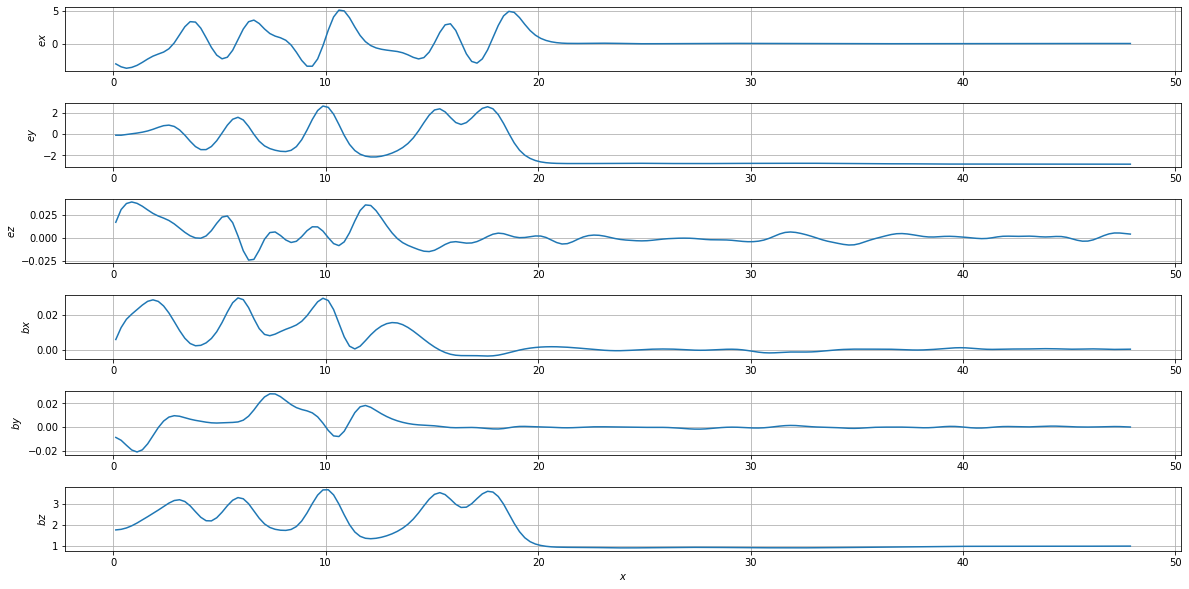

In [10]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

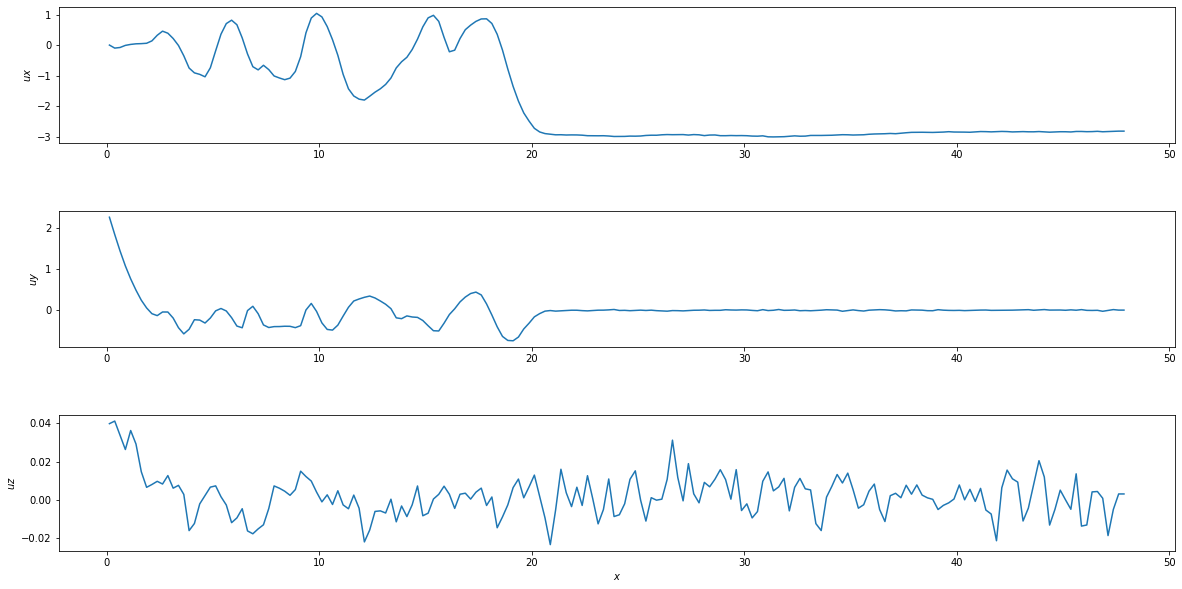

In [11]:
plt1d.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

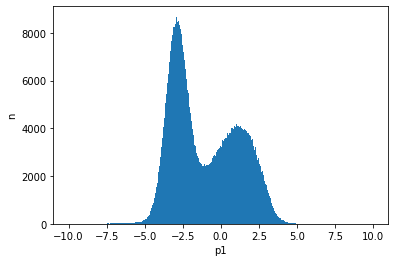

<Figure size 432x288 with 0 Axes>

In [12]:
pltdebug.plot_1d_dist(dparticles, 'p1', 10., xlim[0], xlim[1], ylim[0], ylim[1])

### Compute Shock Vel and Lorentz transform fields

In [13]:
all_dfields = dh5.all_dfield_loader(path=path, verbose=False)


In [14]:
vshock, xshockvals = ft.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


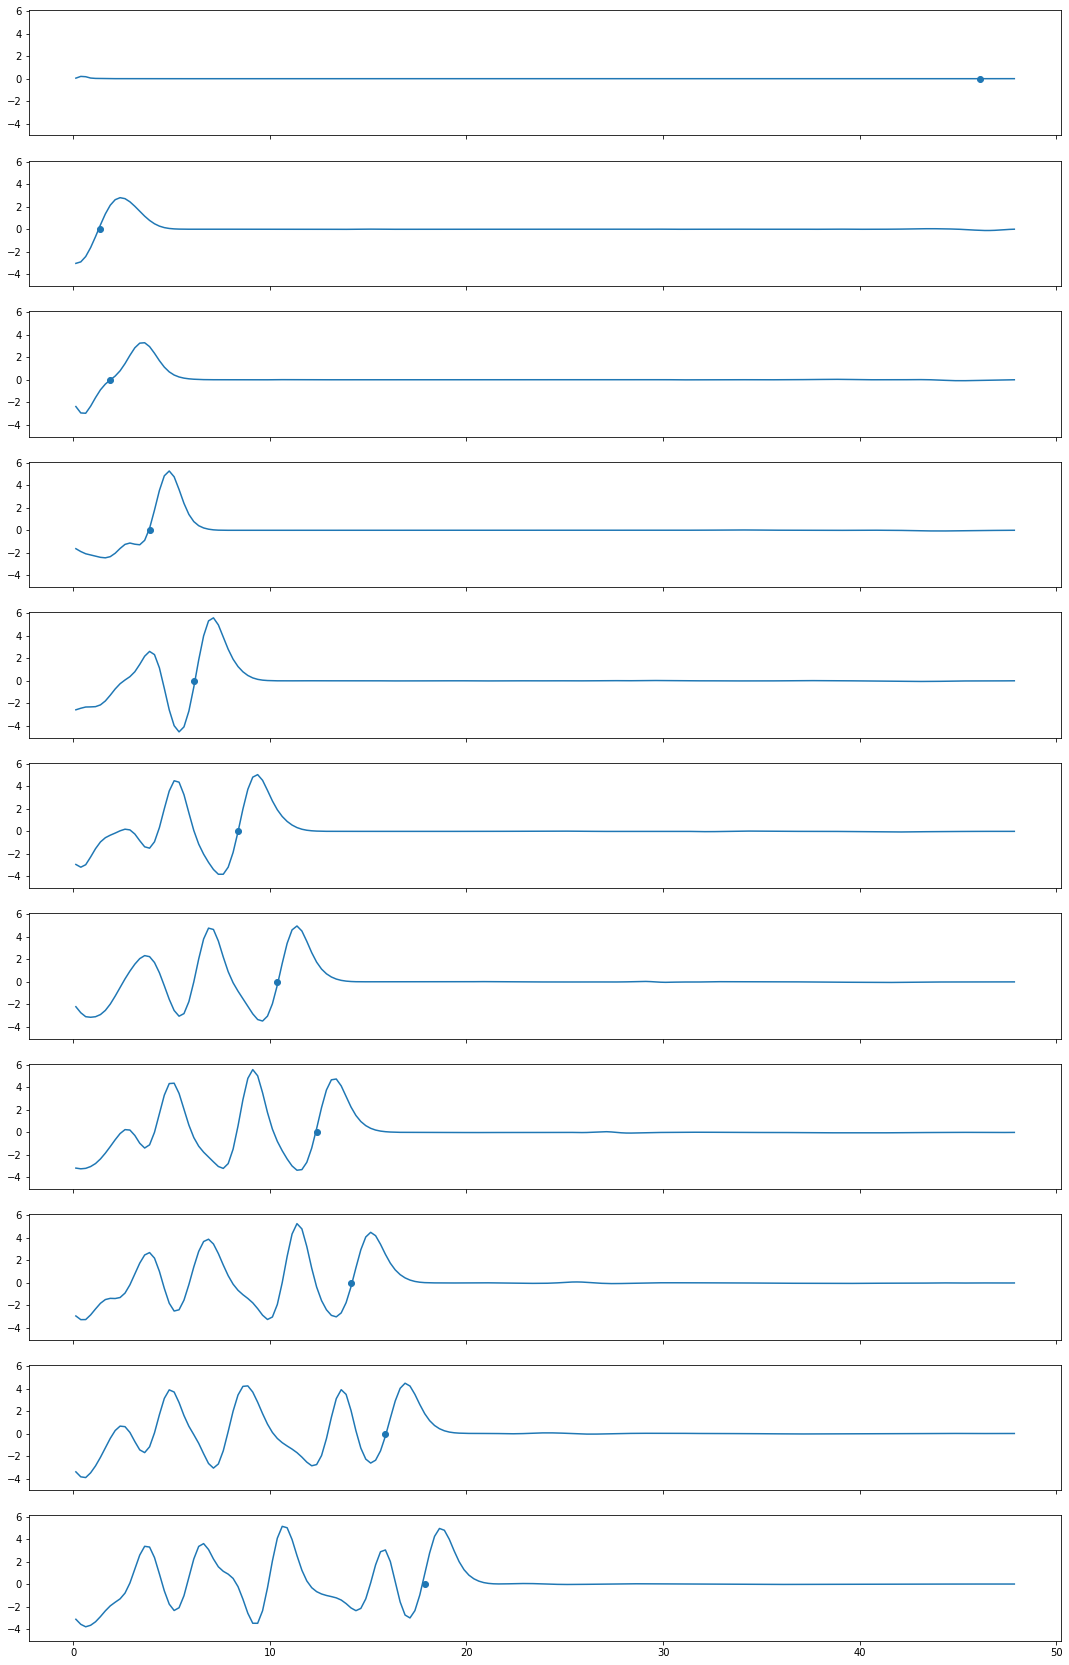

In [15]:
plt1d.time_stack_line_plot(all_dfields,'ex',pts = xshockvals)

In [16]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ft.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

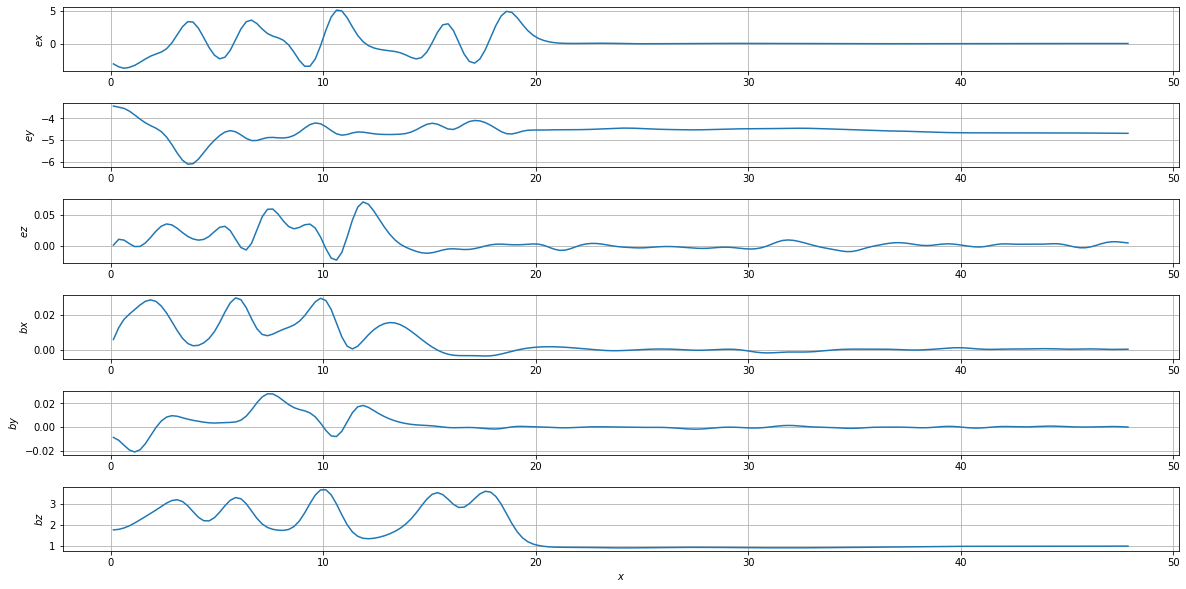

In [17]:
plt1d.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

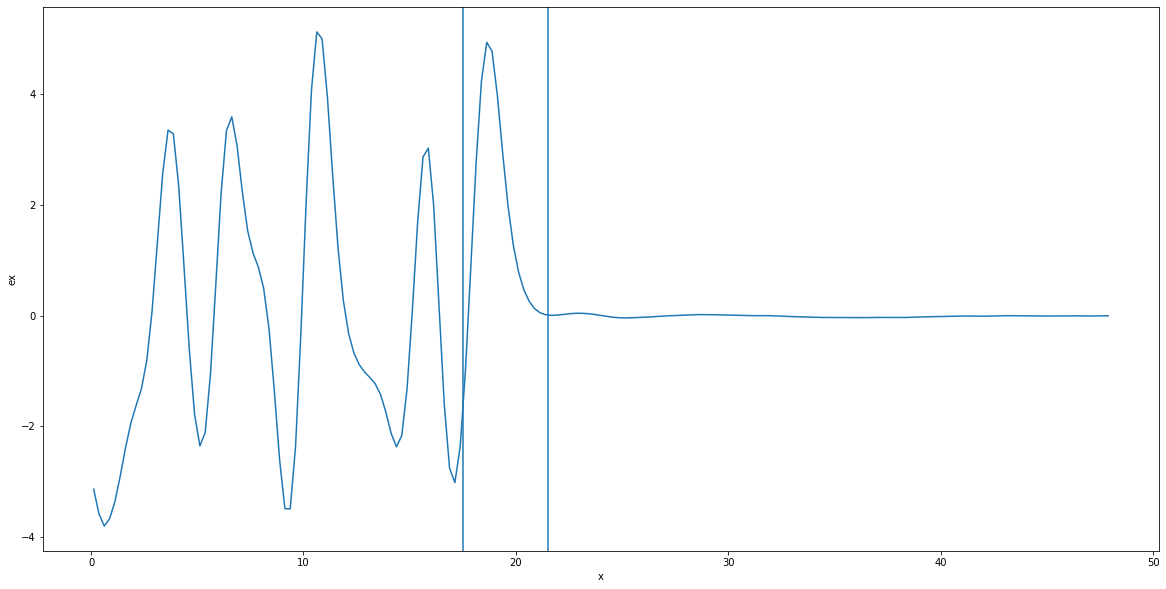

In [32]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.5#lower bound for metadata = 1 (di)
endval = 21.5 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
plt1d.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [33]:
xlim

[15.0, 30.0]

In [34]:
metadata = md.build_metadata(xlim,dx, startval, endval)

In [35]:
metadata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

### Test super plot

In [66]:
x1 = xlim[0]
x2 = xlim[1]
y1 = ylim[0]
y2 = ylim[1] 
z1 = zlim[0] 
z2 = zlim[1]

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles, dfields, vshock, 'ez', 'z')

In [67]:
totalPtcl

1544843

In [68]:
#Project onto correct axes
H_xy = ao.array_3d_to_2d(Hist,'xy')
H_xz = ao.array_3d_to_2d(Hist,'xz')
H_yz = ao.array_3d_to_2d(Hist,'yz')
CEx_xy = ao.array_3d_to_2d(CEx,'xy')
CEx_xz = ao.array_3d_to_2d(CEx,'xz')
CEx_yz = ao.array_3d_to_2d(CEx,'yz')
CEy_xy = ao.array_3d_to_2d(CEy,'xy')
CEy_xz = ao.array_3d_to_2d(CEy,'xz')
CEy_yz = ao.array_3d_to_2d(CEy,'yz')
CEz_xy = ao.array_3d_to_2d(CEz,'xy')
CEz_xz = ao.array_3d_to_2d(CEz,'xz')
CEz_yz = ao.array_3d_to_2d(CEz,'yz')

<Figure size 468x432 with 0 Axes>

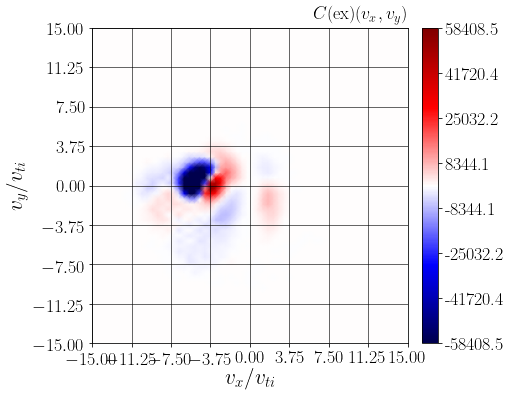

In [69]:

vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.plot_velsig(vx_xy,vy_xy,vmax,CEx_xy,'ex',flnm = '',ttl='')

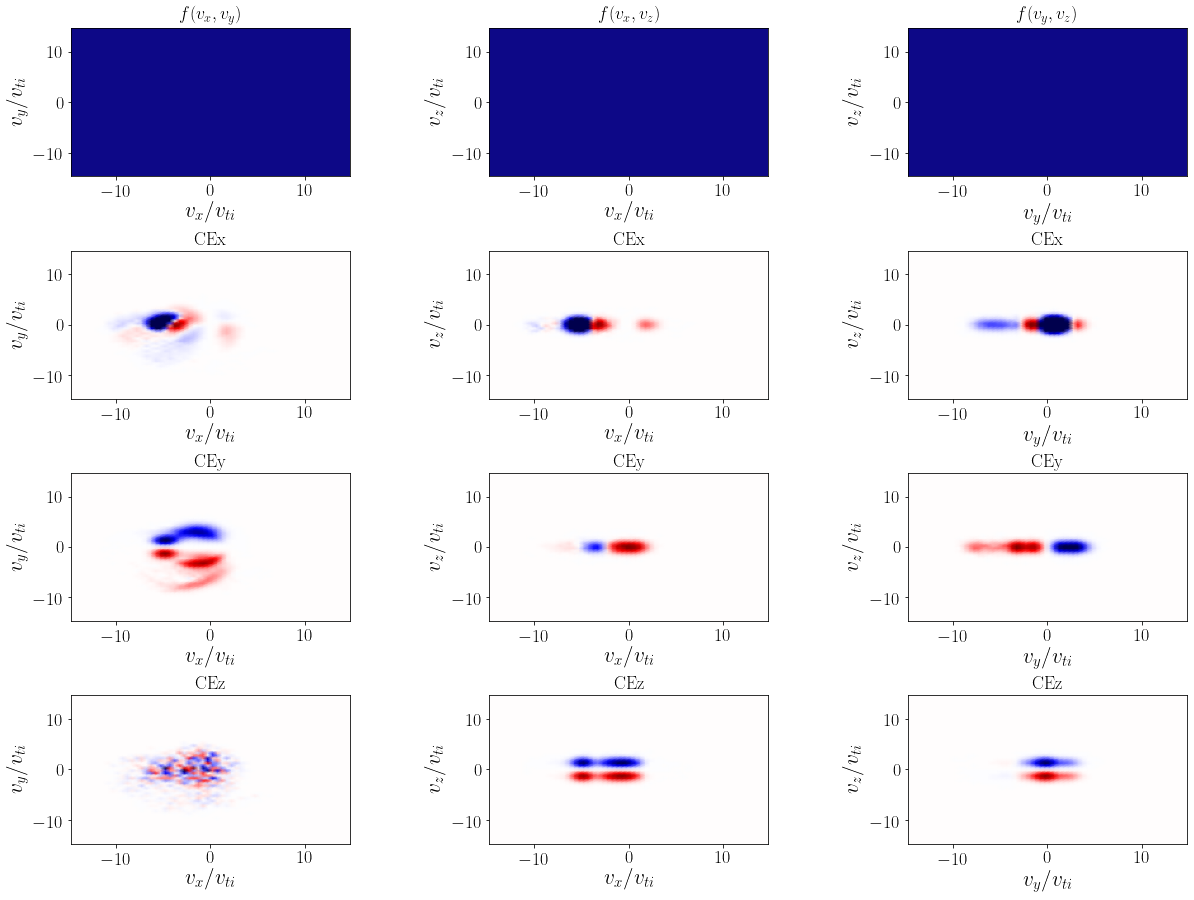

In [70]:
pltvv.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [21]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = fpc.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock,xlim=xlim,ylim=ylim,zlim=zlim)

15.0 15.5 0.0 1.0 0.0 1.0
143589
15.5 16.0 0.0 1.0 0.0 1.0
102521
16.0 16.5 0.0 1.0 0.0 1.0
68054
16.5 17.0 0.0 1.0 0.0 1.0
89280
17.0 17.5 0.0 1.0 0.0 1.0
115348
17.5 18.0 0.0 1.0 0.0 1.0
134697
18.0 18.5 0.0 1.0 0.0 1.0
108666
18.5 19.0 0.0 1.0 0.0 1.0
64457
19.0 19.5 0.0 1.0 0.0 1.0
43216
19.5 20.0 0.0 1.0 0.0 1.0
35606
20.0 20.5 0.0 1.0 0.0 1.0
32815
20.5 21.0 0.0 1.0 0.0 1.0
32222
21.0 21.5 0.0 1.0 0.0 1.0
32270
21.5 22.0 0.0 1.0 0.0 1.0
32131
22.0 22.5 0.0 1.0 0.0 1.0
32259
22.5 23.0 0.0 1.0 0.0 1.0
32116
23.0 23.5 0.0 1.0 0.0 1.0
31421
23.5 24.0 0.0 1.0 0.0 1.0
31453
24.0 24.5 0.0 1.0 0.0 1.0
31036
24.5 25.0 0.0 1.0 0.0 1.0
31500
25.0 25.5 0.0 1.0 0.0 1.0
31749
25.5 26.0 0.0 1.0 0.0 1.0
31993
26.0 26.5 0.0 1.0 0.0 1.0
32081
26.5 27.0 0.0 1.0 0.0 1.0
32225
27.0 27.5 0.0 1.0 0.0 1.0
32374
27.5 28.0 0.0 1.0 0.0 1.0
32378
28.0 28.5 0.0 1.0 0.0 1.0
31976
28.5 29.0 0.0 1.0 0.0 1.0
31760
29.0 29.5 0.0 1.0 0.0 1.0
31690
29.5 30.0 0.0 1.0 0.0 1.0
31956


### Make superplot gif

In [75]:
pltvv.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

Making plot 0 of 30
Making plot 1 of 30
Making plot 2 of 30
Making plot 3 of 30
Making plot 4 of 30
Making plot 5 of 30
Making plot 6 of 30
Making plot 7 of 30
Making plot 8 of 30
Making plot 9 of 30
Making plot 10 of 30
Making plot 11 of 30
Making plot 12 of 30
Making plot 13 of 30
Making plot 14 of 30
Making plot 15 of 30
Making plot 16 of 30
Making plot 17 of 30
Making plot 18 of 30
Making plot 19 of 30
Making plot 20 of 30
Making plot 21 of 30
Making plot 22 of 30
Making plot 23 of 30
Making plot 24 of 30
Making plot 25 of 30
Making plot 26 of 30
Making plot 27 of 30
Making plot 28 of 30
Making plot 29 of 30


In [76]:
rsltmng.make_gif_from_folder('superplotGraphs','superplottest.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png']


### Convert to previous '2v FPC' formatting

In [23]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_2v = []
CEy_2v = []
CEz_2v = []
for i in range(0,len(CEx)):
    CEx_xy = ao.array_3d_to_2d(CEx[i],'xy')
    CEy_xy = ao.array_3d_to_2d(CEy[i],'xy')
    CEz_xy = ao.array_3d_to_2d(CEz[i],'xy')
    CEx_2v.append(CEx_xy)
    CEy_2v.append(CEy_xy)
    CEz_2v.append(CEz_xy)
    
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
x_out = x

#### Compute energization from correlations

In [24]:
#TODO: project onto 2d plane and handle different projections net energization
#Also note, technically, we can project in this order, to compute energization,
#but it is a little confusing to follow
enerCEx_out = anl.compute_energization_over_x(CEx_2v,dv)
enerCEy_out = anl.compute_energization_over_x(CEy_2v,dv)
enerCEz_out = anl.compute_energization_over_x(CEz_2v,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [40]:
inputdict = dnc.parse_input_file(path)

In [41]:
params = dnc.build_params(inputdict,numframe)

In [42]:
inputdict

{'': [''],
 'node_conf_node_number(1:3)': [14.0, 4.0, 4.0],
 'time_dt': [0.01],
 'time_niter': [1000.0],
 'time_t0': [0.0],
 'time_stiter': [0.0],
 'time_c': [125.0],
 'grid_space_ncells(1:3)': [192.0, 48.0, 48.0],
 'grid_space_boxsize(1:3)': [48.0, 12.0, 12.0],
 'grid_space_bdtype': ['reflect', 'open', 'per', 'per', 'per', 'per'],
 'grid_space_Te': [1.0],
 'grid_space_gamma': [1.66667],
 'global_output_dodump': ['.true.'],
 'global_output_ndump': [100.0],
 'global_output_B0': ['3.05191d-7'],
 'global_output_n0': ['1.d6'],
 'global_output_units': ['NORM'],
 'global_output_do_restart': ['.false.'],
 'global_output_save_restart': ['.true.'],
 'global_output_restart_step': [1000.0],
 'global_output_restart_time': [85000.0],
 'global_output_restart_time_step': [100.0],
 'ext_emf_Bx': [0.0],
 'ext_emf_By': [0.0],
 'ext_emf_Bz': [1.0],
 'ext_emf_Ex': [0.0],
 'ext_emf_Ey': [0.0],
 'ext_emf_Ez': [0.0],
 'ext_emf_n_constants': [0.0],
 'ext_emf_Jext(1:3)': [0.0, 0.0, 0.0],
 'ext_emf_NoiseLevel(1

In [43]:
params

{'MachAlfven': -3.0,
 'MachAlfvenNote': 'TODO: compute mach alfven for this run',
 'thetaBn': 90.0,
 'thetaBndesc': 'units of degrees',
 'betaelec': 1.0,
 'betaion': 0.5000000000190247,
 'simtime': 10.0,
 'simtimedesc': 'units of inverse Omega_{c,i,0}',
 'qi': 1.0,
 'qidesc': 'charge to mass ratio',
 'di': 0.0,
 'didesc': 'TODO: compute ion inertial length',
 'vti': 0.7071067812}

In [45]:
metadata

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
savenewfmt = True
if(savenewfmt):
    flnm = '3Vtest1.nc'
    try:
        dnc.save3Vdata(CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.save3Vdata(CEx, CEy, CEz, vx, vy, vz, x_out, enerCEx_out, enerCEy_out, enerCEz_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
else:
    flnm = '2Vtest.nc'
    try:
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)
    except:
        os.system('rm '+flnm)
        dnc.savedata(CEx_2v, CEy_2v, vx_xy, vy_xy, x_out, enerCEx_out, enerCEy_out, dfields['Vframe_relative_to_sim'], metadata_out = metadata, params = params, filename = flnm)

Saving data into netcdf4 file


### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [131]:
if(savenewfmt):
    CEx_in, CEy_in, CEz_in, vx_in, vy_in, vz_in, x_in, enerCEx_in, enerCEy_in, enerCEz_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load3Vnetcdf4(flnm)
else:
    CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, Vframe_relative_to_sim, metadata_in, params_in = dnc.load_netcdf4(flnm)

### Perform sanity checks
#### E cross B gif

In [132]:
dfields['bz_zz']

array([ 0.125,  0.375,  0.625,  0.875,  1.125,  1.375,  1.625,  1.875,
        2.125,  2.375,  2.625,  2.875,  3.125,  3.375,  3.625,  3.875,
        4.125,  4.375,  4.625,  4.875,  5.125,  5.375,  5.625,  5.875,
        6.125,  6.375,  6.625,  6.875,  7.125,  7.375,  7.625,  7.875,
        8.125,  8.375,  8.625,  8.875,  9.125,  9.375,  9.625,  9.875,
       10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875])

In [136]:
CEx_xy

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([

Making plot 0 of 30


ValueError: cannot reshape array of size 216000 into shape (1,60)

<Figure size 468x432 with 0 Axes>

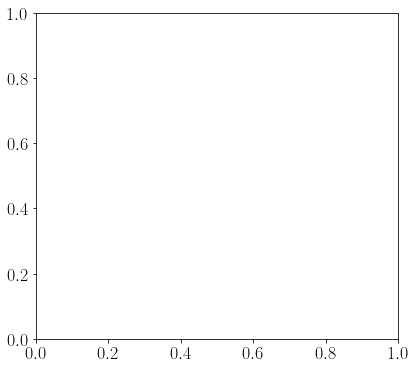

In [135]:
CEx_xy = [ao.array_3d_to_2d(CEx[i],'xy') for i in range(0,len(CEx))]
vx_xy, vy_xy = ao.mesh_3d_to_2d(vx,vy,vz,'xy')
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_xy, 'ex', x_out, dx, dfields, 'CExExB', 'CExExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CExExB', 'CExExB.gif')

<img src="CExExB.gif" width="750" align="center">

In [ ]:
pltvv.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_in, 'ex', x_out, dx, dfields, 'CEyExB', 'CEyExB.gif', xlim = xlim, ylim = ylim, zlim = zlim)

In [ ]:
rsltmng.make_gif_from_folder('CEyExB', 'CEyExB.gif')

<img src="CEyExB.gif" width="750" align="center">

##  Plot fields as a function of time

In [ ]:
#Plots Ex(x=xxpltpoint,y=0,z=0;t)
xxpltpoint = 20.0 #di
xxindex = ao.find_nearest(dfields['ex_xx'], xxpltpoint)
plt1d.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [ ]:
anl.get_abs_max_velocity(dparticles)

### Test making field pmesh

In [ ]:
xxindex = 164
plt2d.make_field_pmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',takeaxisaverage=False,yyindex = 0,xlimmin=35,xlimmax=45)

In [ ]:
xx = 40.0
xxindex = ao.find_nearest(dfields['ex_xx'], xx)
plt2d.compare_pmesh_fields_yz(dfields, flnm = '', ttl ='x (di): ' + str(dfields['ex_xx'][xxindex]), takeaxisaverage=False, xxindex=xxindex)

In [ ]:
plt2d.compare_pmesh_fields_yz_sweep(dfields,'pmeshsweep')

In [ ]:
rsltmng.make_gif_from_folder('pmeshsweep', 'pmeshsweep.gif')

### Estimate Ripple size

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)

In [ ]:
plt1d.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

### Test 2d fourier (WIP)

In [ ]:
startval = 39.
endval = 40.5
plt1d.plot_field(dfields, 'bz', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
k0, k1, fieldpmesh, xplot, yplot = pltfr.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

### Test Energization vs J dot E (WIP)

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
dflowtransform = ft.transform_flow(dflow,vshock)
pltdebug.check_JiEi_vs_CEi(dfields,dflowtransform,dparticles,x_in,enerCEx_in,enerCEy_in,dx,xlim=xlim,ylim=ylim,zlim=zlim)

In [ ]:
dflowtransform['Vframe_relative_to_sim']

In [ ]:
vshock

In [ ]:
dfields['Vframe_relative_to_sim']

### Test averaging out shock event

In [52]:
def remove_average_fields_over_yz(dfields):
    from copy import copy

    dfieldfluc = copy(dfields) #deep copy
    dfieldfluc['ex'] = dfields['ex']-dfields['ex'].mean(axis=(0,1))
    dfieldfluc['ey'] = dfields['ey']-dfields['ey'].mean(axis=(0,1))
    dfieldfluc['ez'] = dfields['ez']-dfields['ez'].mean(axis=(0,1))
    dfieldfluc['bx'] = dfields['bx']-dfields['bx'].mean(axis=(0,1))
    dfieldfluc['by'] = dfields['by']-dfields['by'].mean(axis=(0,1))
    dfieldfluc['bz'] = dfields['bz']-dfields['bz'].mean(axis=(0,1))
    
    return dfieldfluc
    

In [53]:
dfieldfluc = remove_average_fields_over_yz(dfields)

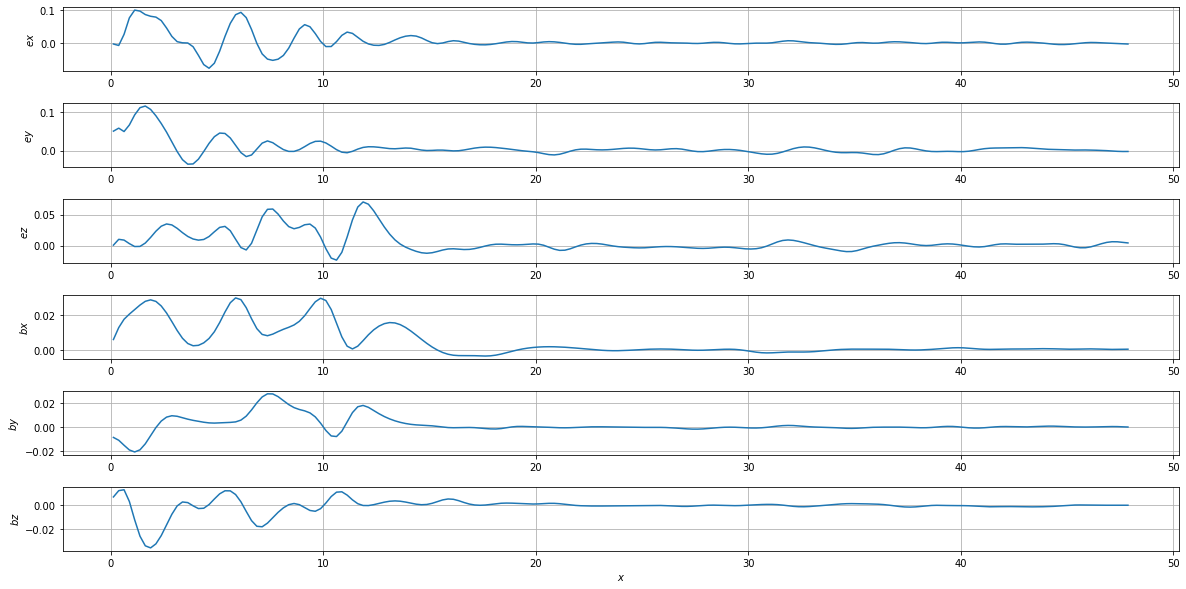

In [54]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)#,lowxlim=15,highxlim=25)

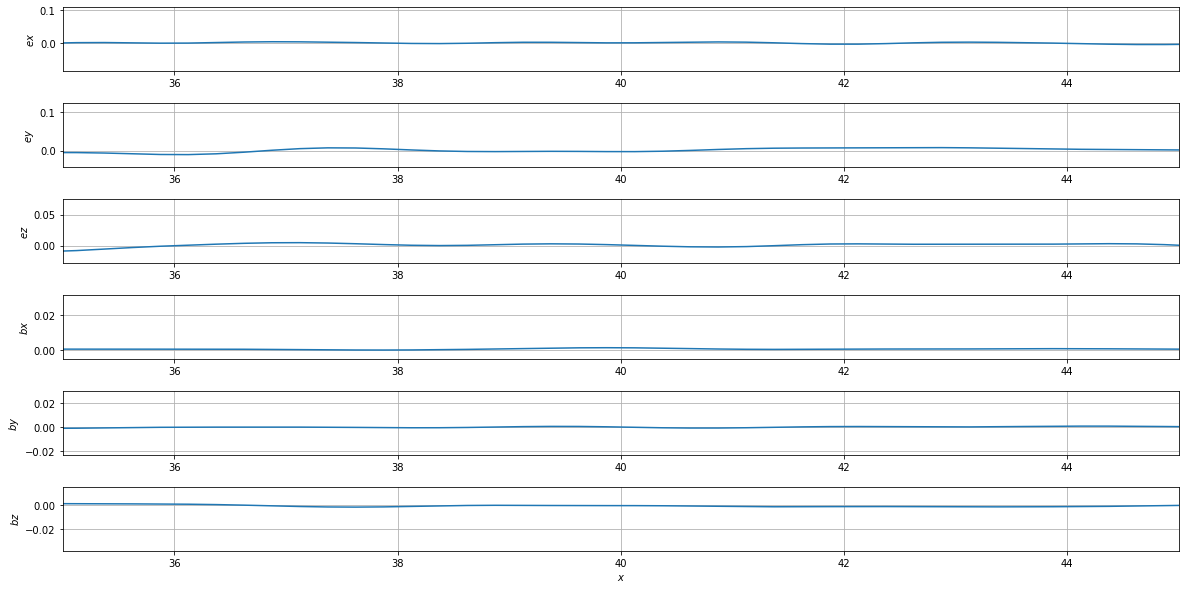

In [55]:
plt1d.plot_all_fields(dfieldfluc, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0,lowxlim=35,highxlim=45)

In [ ]:
import matplotlib.pyplot as plt
def compare_fields(dfields1, dfields2, fieldkey, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = ''):
    """
 
    """


    if(axis == '_zz'):
        fieldval1 = np.asarray([dfields1[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][i][yyindex][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'z'
    elif(axis == '_yy'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][i][xxindex] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'y'
    elif(axis == '_xx'):
        fieldval1 = np.asarray([dfields1[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields1[fieldkey+axis]))])
        fieldval2 = np.asarray([dfields2[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields2[fieldkey+axis]))])
        xlbl = 'x'

    fieldcoord1 = np.asarray(dfields1[fieldkey+axis])
    fieldcoord2 = np.asarray(dfields2[fieldkey+axis])

    plt.figure(figsize=(20,10))
    plt.xlabel(xlbl)
    plt.ylabel(fieldkey)
    plt.plot(fieldcoord1,fieldval1)
    plt.plot(fieldcoord2,fieldval2)
    if(not(axvx1 != axvx1)): #if not nan
        plt.axvline(x=axvx1)
    if(not(axvx2 != axvx2)): #if not nan
        plt.axvline(x=axvx2)
    if(flnm == ''):
        plt.show()
    else:
        plt.savefig(flnm,format='png')
    plt.close()

In [ ]:
compare_fields(dfields, dfieldfluc, 'ex', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ey', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'ez', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bx', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'by', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
compare_fields(dfields, dfieldfluc, 'bz', axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0, axvx1 = float('nan'), axvx2 = float('nan'), flnm = '')

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xy',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=float('nan'), zzindex=0, xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfieldfluc,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
plt2d.make_field_pmesh(dfields,'bz','xz',flnm = '',takeaxisaverage=False, xxindex=float('nan'), yyindex=0, zzindex=float('nan'), xlimmin=25,xlimmax=45)

In [ ]:
def plot1d_fft(dfields,fieldkey):
    axis = '_xx'
    zzindex = 0
    yyindex = 0
    data = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
    dx = dfields[fieldkey+axis][1]-dfields['ex_xx'][0]
    
    
    k0 = 2.*np.pi*np.fft.fftfreq(len(data),dx)
    k0 = k0[0:int(len(k0)/2)]

    fftdata = np.fft.fft(data)
    fftdata = np.real(fftdata*np.conj(fftdata))
    fftdata = fftdata[0:int(len(fftdata)/2)]
    
    plt.figure()
    plt.xlabel('k'+axis[1:2])
    plt.ylabel(fieldkey+' Power')
    plt.plot(k0,fftdata)
    plt.show()
    
    
    return k0,fftdata

In [ ]:
k0,fftdata = plot1d_fft(dfieldfluc,'ex')

In [ ]:
k0,fftdata = plot1d_fft(dfieldfluc,'ey')

In [ ]:
k0,fftdata = plot1d_fft(dfieldfluc,'ez')

In [ ]:
k0,fftdata = plot1d_fft(dfieldfluc,'bx')

In [ ]:
bk0,fftdata = plot1d_fft(dfieldfluc,'by')

In [ ]:
bk0,fftdata = plot1d_fft(dfieldfluc,'bz')